In [68]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.metrics import BinaryAccuracy
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [69]:
# Directory Path
BASE_DIR = 'Dataset2'
print(f"Base Directory: {os.listdir(BASE_DIR)}")

data_train='Dataset2/train'
print(f"Data Directory: {os.listdir(data_train)}")
data_validation='Dataset2/valid'
print(f"Data Directory: {os.listdir(data_validation)}")

Base Directory: ['LokaJamu-7.txt', 'train', 'valid']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']


In [70]:
# Define constants
BATCH_SIZE = 32  # Set your batch size
NUM_CLASSES = 7  # Set the number of classes
CLASS_MODE='categorical'

In [71]:
# Data augmentation for training and rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [72]:
# Use binary class mode for multi-label classification
train_generator = train_datagen.flow_from_directory(
    data_train,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE # Change to 'binary' for multi-label
)

validation_generator = test_datagen.flow_from_directory(
    data_validation,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE # Change to 'binary' for multi-label
)


Found 2055 images belonging to 7 classes.
Found 487 images belonging to 7 classes.


In [73]:
# Load the pre-trained MobileNetV2 model
pre_trained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False)

# Freeze the layers of the pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False


In [74]:
def based_model():
    model = tf.keras.models.Sequential([
        pre_trained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')  # Change to sigmoid for multi-label
    ])
    return model


In [75]:
model = based_model()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,287,175 (39.24 MB)

 Trainable params: 8,029,191 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [76]:

# Compile the model with binary crossentropy loss
model.compile(loss='binary_crossentropy',  # Change to binary_crossentropy
              optimizer=tf.optimizers.Adam(),
              metrics=[BinaryAccuracy()])


In [77]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric yang diamati
    patience=5,          # Epoch tanpa perbaikan sebelum pelatihan dihentikan
    restore_best_weights=True  # Kembalikan bobot terbaik setelah pelatihan berhenti
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric yang diamati
    factor=0.1,          # Faktor pengurangan learning rate (misal, dikali 0.1)
    patience=3,          # Epoch tanpa perbaikan sebelum learning rate dikurangi
    min_lr=1e-6          # Batas minimum learning rate
)


# Callbacks
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('binary_accuracy')
        val_accuracy = logs.get('val_binary_accuracy')

        if val_accuracy >= 0.85:
            self.model.stop_training = True
            print("\nReached 95% train accuracy and 85% validation accuracy, so cancelling training!")


In [78]:
epoch = 100
history = model.fit(train_generator, 
                    batch_size=BATCH_SIZE, 
                    epochs=epoch, 
                    validation_data=validation_generator, 
                    shuffle=True,)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/65 ━━━━━━━━━━━━━━━━━━━━ 39s 867ms/step - binary_accuracy: 0.8001 - loss: 2.2937

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 66s 962ms/step - binary_accuracy: 0.8628 - loss: 1.4294 - val_binary_accuracy: 0.9692 - val_loss: 0.0797
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 61s 931ms/step - binary_accuracy: 0.9423 - loss: 0.1611 - val_binary_accuracy: 0.9798 - val_loss: 0.0599
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 60s 925ms/step - binary_accuracy: 0.9572 - loss: 0.1094 - val_binary_accuracy: 0.9780 - val_loss: 0.0691
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 55s 840ms/step - binary_accuracy: 0.9561 - loss: 0.1221 - val_binary_accuracy: 0.9824 - val_loss: 0.0507
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 56s 866ms/step - binary_accuracy: 0.9577 - loss: 0.1111 - val_binary_accuracy: 0.9853 - val_loss: 0.0466
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - binary_accuracy: 0.9627 - loss: 0.0961 - val_binary_accuracy: 0.9839 - val_loss: 0.0474
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 65s 993ms/step - binary_accuracy: 0.9625 - loss: 0.0882 - val_binary_accuracy: 0.9821 - val_loss: 0.0446
Epoch 8/10
65

In [79]:
ds = validation_generator
print("Test Accuracy", model.evaluate(ds)[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 652ms/step - binary_accuracy: 0.9889 - loss: 0.0325
Test Accuracy 0.9862129092216492


In [80]:
print("Loss Accuracy", model.evaluate(ds)[0])

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 611ms/step - binary_accuracy: 0.9816 - loss: 0.0414
Loss Accuracy 0.03663066402077675


In [81]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']

train_acc= history.history['binary_accuracy']
val_acc= history.history['val_binary_accuracy']

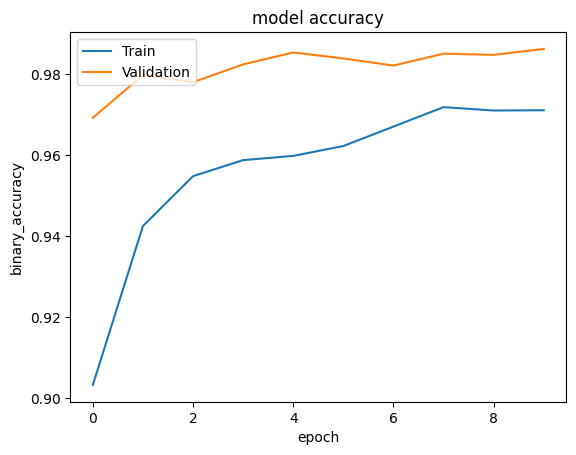

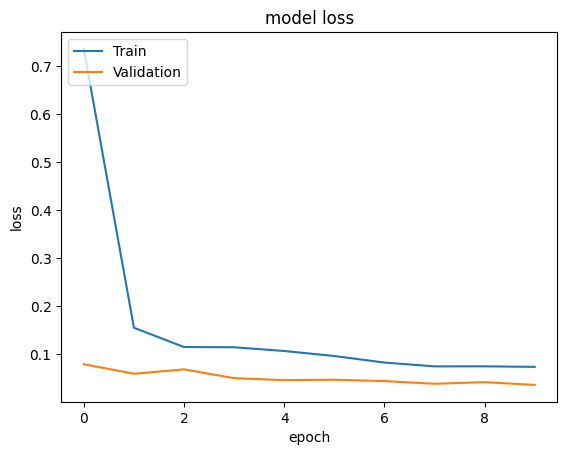

In [82]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title("model accuracy")
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(["Train", 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel('epoch')
plt.legend(["Train", 'Validation'], loc='upper left')
plt.show()